In [ ]:
!nvidia-smi

Wed Mar  9 13:16:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    23W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from imutils import paths
import skimage.measure
from google.colab.patches import cv2_imshow

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i] = img
            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

In [ ]:
def AE(input_shape):
  X_input = Input(shape = input_shape)  
  #encoding architecture
  x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(X_input)
  x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
  x3 = MaxPooling2D(padding='same')(x2)
  x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
  x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
  x6 = MaxPooling2D(padding='same')(x5)
  encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
  # decoding architecture
  x7 = Conv2DTranspose(256, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(encoded)
  x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
  x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
  x10 = Add()([x5, x9])
  x11 = Conv2DTranspose(128, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(x10)
  x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
  x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
  x14 = Add()([x2, x13])
  decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
  model = Model(inputs = X_input, outputs = decoded, name = 'AESR')
  return model


In [ ]:
model = AE((256,256,3))
model.summary()

Model: "AESR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

In [ ]:
model.compile(optimizer='adam', loss = 'mse')

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

In [ ]:
early = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights = True)
checkpoint = ModelCheckpoint('/content/drive/Shareddrives/PMAT/Final/weights/AE.h5',save_best_only=True)

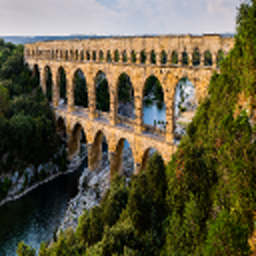

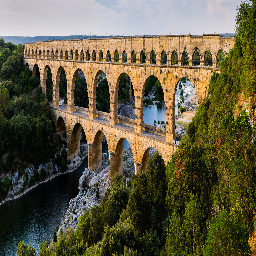

In [ ]:
img_lr= train_data_generator[10][0][-1]
img_hr=train_data_generator[10][1][-1]
cv2_imshow(img_lr)
cv2_imshow(img_hr)

In [ ]:
H= model.fit(train_data_generator,validation_data=val_data_generator,verbose = 1, epochs = 100, callbacks=[early, checkpoint])

Epoch 1/100
100/100 [==============================] - 283s 3s/step - loss: 1828.6464 - val_loss: 478.0489
Epoch 2/100
100/100 [==============================] - 191s 2s/step - loss: 456.5692 - val_loss: 454.5656
Epoch 3/100
100/100 [==============================] - 188s 2s/step - loss: 429.9990 - val_loss: 434.2856
Epoch 4/100
100/100 [==============================] - 186s 2s/step - loss: 418.1948 - val_loss: 422.7937
Epoch 5/100
100/100 [==============================] - 187s 2s/step - loss: 410.0470 - val_loss: 420.5063
Epoch 6/100
100/100 [==============================] - 186s 2s/step - loss: 406.2303 - val_loss: 417.1959
Epoch 7/100
100/100 [==============================] - 183s 2s/step - loss: 404.9927 - val_loss: 409.2729
Epoch 8/100
100/100 [==============================] - 186s 2s/step - loss: 411.9616 - val_loss: 433.0978
Epoch 9/100
100/100 [==============================] - 185s 2s/step - loss: 402.3828 - val_loss: 409.7328
Epoch 10/100
100/100 [=======================

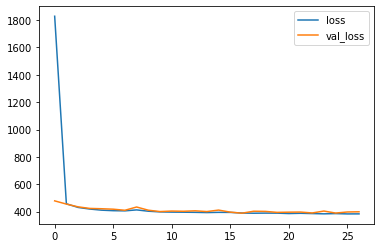

In [ ]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
test_img=img_lr.reshape([1,*img_lr.shape])

In [ ]:
test_img.shape

(1, 256, 256, 3)

In [ ]:
output= model.predict(test_img)

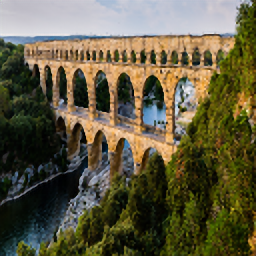

In [ ]:
cv2_imshow(output[0])

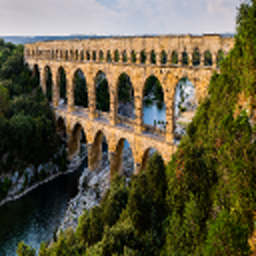

In [ ]:
cv2_imshow(img_lr)

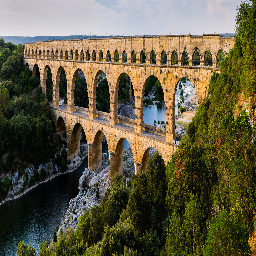

In [ ]:
cv2_imshow(img_hr)